In [27]:
%load_ext autoreload
%autoreload 2


In [56]:
from toolkit.process import AnalysisObject
from toolkit.populations import definePremotorPopulation
from toolkit.populations import defineVisualPopulation
from toolkit.saccades import parseSaccadeType
from toolkit.saccades import calculateSaccadeAmplitudes
from toolkit.saccades import calculateSaccadeStartPoint
from toolkit.saccades import calculateSaccadeEndPoint
from toolkit.populations import createTrialArray
from toolkit.populations import specifyTrialTypes
from toolkit.populations import trialAveragedPCA
from toolkit.plots import plotPCA3D
import os
import numpy as np

In [8]:
fileList = ['/media/jbhunt/Seagate Portable Drive/2023-07-31/mlati10',
           '/media/jbhunt/Seagate Portable Drive/2023-07-24/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-25/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-07-26/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-27/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-07-28/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-31/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-08-01/mlati10']

In [9]:
for base in fileList:
    h5file = os.path.join(base, 'output.hdf')
    clusterFile = os.path.join(base,'ephys/sorting/manual/spike_clusters.npy')
    premotorUnits = definePremotorPopulation(h5file, clusterFile)
    visualUnits = defineVisualPopulation(h5file, clusterFile)
    print(premotorUnits)
    print(visualUnits)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [6]:
for base in fileList[0:1]:
    h5file = os.path.join(base, 'output.hdf')
    driven, spontaneous = parseSaccadeType(h5file)
    amplitudes = calculateSaccadeAmplitudes(h5file, spontaneous)
    starts = calculateSaccadeStartPoint(h5file, spontaneous)
    ends = calculateSaccadeEndPoint(h5file, spontaneous)
    print(starts, ends)
    #print(amplitudes)

[-2.861279517351594, -2.8463486364687745, -3.16619229468329, -3.187677750296557, -3.1686998294079243, -2.9499225830455402, -2.763725153376696, -2.249013213360768, -3.48577838108964, -3.4906390272469476, -3.53679025781901, -2.9486707040099813, -2.993416087950256, -2.5973184032853363, -2.67975705415683, -3.2009794157893365, 0.4534397671729229, 0.3239741257406733, 0.12155619890422617, 0.1818219566842989, 0.1412319495945511] [9.246746819355941, 14.807534660375481, -0.29312804304030127, 6.266473589923149, 12.337999885458423, -2.3242131750010953, -0.5651904993089957, 1.402196111543709, -0.8323121417861616, 6.203787168846832, 8.811574527256555, 9.214796104650448, 1.6067837620155299, 16.123865627300535, 3.1652300212611175, 8.380720773887933, 3.0484696549747783, -6.193584366047802, -5.6538099692241275, -1.823747284088594, -4.299723507975522]


In [29]:
session = AnalysisObject(h5file)
totalSaccadeTimes = session.load('saccades/predicted/left/timestamps')[:, 0]

In [34]:
import numpy as np
for time in spontaneous:
    print(np.where(totalSaccadeTimes == time)[0])


[620]
[658]
[723]
[831]
[905]
[906]
[907]
[1049]
[1107]
[1265]
[1565]
[1820]
[1846]
[1911]
[1938]
[1981]
[1982]
[1983]
[1984]
[2050]
[2141]


In [61]:
bins = np.arange(-0.5, 0.6, 0.1)
session = AnalysisObject(h5file)
population = session._population()
unitList = list()
for unit in population:
    unitList.append(unit.cluster)
#trials = session.load('saccades/predicted/left/timestamps')[:, 0]
trials = session.load('stimuli/dg/probe/timestamps')
trialList = createTrialArray(h5file, bins, unitList, trials)

In [89]:
t_type_ind, trial_types = specifyTrialTypes(h5file, saccade=False)
pcs = trialAveragedPCA(trialList, t_type_ind, trial_types, 20)

(20, 20)


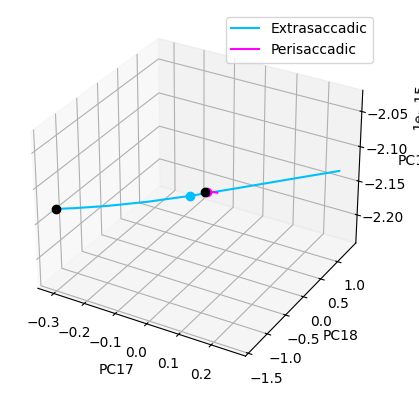

In [92]:
dimensions = [17, 18, 19]
ax = plotPCA3D(pcs, trial_types, dimensions, 4)

In [76]:
pcs.shape

(10, 10, 2)

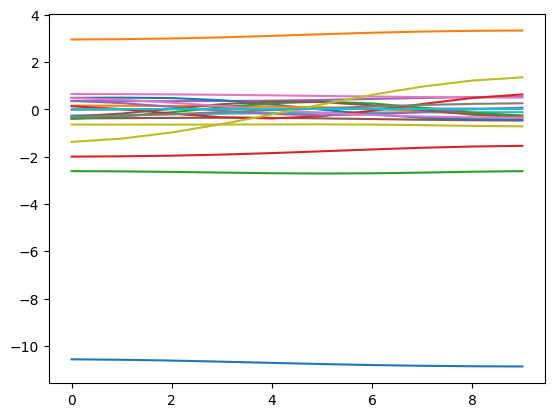

In [90]:
import matplotlib.pyplot as plt
plt.plot(pcs[:,:,0].T)
#plt.plot(pcs[0,:,1])